# ResNet Comparison
### Author: WonJae Lee

This project aims to compare different configurations of ResNet on CIFAR-10 dataset for image classification to decide the best performing model for the dataset. We conducted experiments by varying the number of ResNet layers (18, 34, 50), pooling function (avg, max), and the optimizers (SGD, Adam), resulting in the following 12 ResNet configurations:

ResNet-18 + max pooling + SGD

ResNet-18 + max pooling + Adam

ResNet-18 + avg pooling + SGD

ResNet-18 + avg pooling + Adam

ResNet-34 + max pooling + SGD

ResNet-34 + max pooling + Adam

ResNet-34 + avg pooling + SGD

ResNet-34 + avg pooling + Adam

ResNet-50 + max pooling + SGD

ResNet-50 + max pooling + Adam

ResNet-50 + avg pooling + SGD

ResNet-50 + avg pooling + Adam



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Prepare for Dataset

We will use the CIFAR-10 dataset from torchvision library, and we will normalize the images. The dataset contains 10 different classes: plane, car, bird, cat, deer, dog, frog, horse, ship, and truck.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


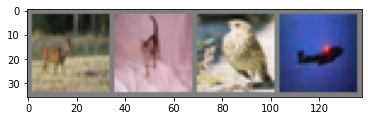

 deer   cat  bird plane


In [3]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


We define a function that takes in ResNet version and pooling function to initialize models with the specific configurations. Here, we set out_features to 10 because we know there are 10 classes in our dataset.

In [5]:
def get_resnet_model(version='resnet18', pooling_type='max'):
    if version == 'resnet18':
        model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    elif version == 'resnet34':
        model = models.resnet34(weights=ResNet34_Weights.DEFAULT)
    elif version == 'resnet50':
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    
    if pooling_type == 'avg':
        model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    elif pooling_type == 'max':
        model.avgpool = nn.AdaptiveMaxPool2d((1, 1))
    
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=10)
    
    return model

Now, we train the 12 total combinations of models and save relevant informations like  version, pooling_type, optimizer, avg_loss, accuracy, class_acc, and model.

In [6]:
versions = ['resnet18', 'resnet34', 'resnet50']
pooling_types = ['max', 'avg']
optimizers = {'adam': optim.Adam, 'sgd': optim.SGD}
loss_func = nn.CrossEntropyLoss()

results = []

for version in versions:
    for pooling_type in pooling_types:
        for opt_name, opt_func in optimizers.items():
            print(f"Experiment: {version}, Pooling: {pooling_type}, Optimizer: {opt_name}")
            model = get_resnet_model(version=version, pooling_type=pooling_type)
            model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = opt_func(model.parameters(), lr=0.001)  # Adjust hyperparameters as needed

            avg_losses = []   # Avg. losses.
            epochs = 10       # Total epochs.
            print_freq = 5000  # Print frequency.

            for epoch in range(epochs):  # Loop over the dataset multiple times.
                running_loss = 0.0       # Initialize running loss.
                for i, data in enumerate(trainloader, 0):
                    # Get the inputs.
                    inputs, labels = data

                    # Move the inputs to the specified device.
                    inputs, labels = inputs.to(device), labels.to(device)

                    # Zero the parameter gradients.
                    optimizer.zero_grad()

                    # Forward step.
                    outputs = model(inputs)
                    loss = loss_func(outputs, labels)

                    # Backward step.
                    loss.backward()

                    # Optimization step (update the parameters).
                    optimizer.step()

                    # Print statistics.
                    running_loss += loss.item()
                    if i % print_freq == print_freq - 1: # Print every several mini-batches.
                        avg_loss = running_loss / print_freq
                        print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(epoch, i, avg_loss))
                        avg_losses.append(avg_loss)
                        running_loss = 0.0
                        

            print('Finished Training.')
            
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            
            # Get test accuracy for each class.
            class_acc = []
            class_correct = list(0. for i in range(10))
            class_total = list(0. for i in range(10))
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    c = (predicted == labels).squeeze()
                    for i in range(4):
                        label = labels[i]
                        class_correct[label] += c[i].item()
                        class_total[label] += 1

            for i in range(10):
                class_acc.append('Accuracy of %5s : %2d %%' % (
                    classes[i], 100 * class_correct[i] / class_total[i]))
            
            results.append({
                'version': version,
                'pooling_type': pooling_type,
                'optimizer': opt_name,
                'avg_loss': avg_losses,
                'accuracy': accuracy,
                'class_acc': class_acc,
                'model': model
            })

Experiment: resnet18, Pooling: max, Optimizer: adam
[epoch: 0, i:  4999] avg mini-batch loss: 2.383
[epoch: 0, i:  9999] avg mini-batch loss: 2.176
[epoch: 1, i:  4999] avg mini-batch loss: 2.036
[epoch: 1, i:  9999] avg mini-batch loss: 1.929
[epoch: 2, i:  4999] avg mini-batch loss: 1.751
[epoch: 2, i:  9999] avg mini-batch loss: 1.639
[epoch: 3, i:  4999] avg mini-batch loss: 1.515
[epoch: 3, i:  9999] avg mini-batch loss: 1.470
[epoch: 4, i:  4999] avg mini-batch loss: 1.409
[epoch: 4, i:  9999] avg mini-batch loss: 1.337
[epoch: 5, i:  4999] avg mini-batch loss: 1.313
[epoch: 5, i:  9999] avg mini-batch loss: 1.264
[epoch: 6, i:  4999] avg mini-batch loss: 1.193
[epoch: 6, i:  9999] avg mini-batch loss: 1.195
[epoch: 7, i:  4999] avg mini-batch loss: 1.159
[epoch: 7, i:  9999] avg mini-batch loss: 1.115
[epoch: 8, i:  4999] avg mini-batch loss: 1.113
[epoch: 8, i:  9999] avg mini-batch loss: 1.101
[epoch: 9, i:  4999] avg mini-batch loss: 1.049
[epoch: 9, i:  9999] avg mini-batch 

Because the training takes a long time, we save the trained models using pickle.

In [6]:
import pickle

# with open('results.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [7]:
with open('results.pkl', 'rb') as f:
    pkl = pickle.load(f)


In [8]:
pkl

[{'version': 'resnet18',
  'pooling_type': 'max',
  'optimizer': 'adam',
  'avg_loss': [2.3830058534026146,
   2.175640135931969,
   2.036349908876419,
   1.9285238191008567,
   1.750716401553154,
   1.639212390244007,
   1.5152053354740143,
   1.4697045574307441,
   1.4089140662670137,
   1.3368305223912,
   1.3126504167199136,
   1.2637714732825756,
   1.1925504169270396,
   1.1952512601554395,
   1.1587313720181585,
   1.1152591843947768,
   1.1125949611946941,
   1.1008809475980699,
   1.049187705259025,
   1.0530445254705847],
  'accuracy': 63.56,
  'class_acc': ['Accuracy of plane : 67 %',
   'Accuracy of   car : 76 %',
   'Accuracy of  bird : 47 %',
   'Accuracy of   cat : 28 %',
   'Accuracy of  deer : 56 %',
   'Accuracy of   dog : 62 %',
   'Accuracy of  frog : 74 %',
   'Accuracy of horse : 75 %',
   'Accuracy of  ship : 76 %',
   'Accuracy of truck : 71 %'],
  'model': ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1

Then, we plot the loss curve for each model configuration.

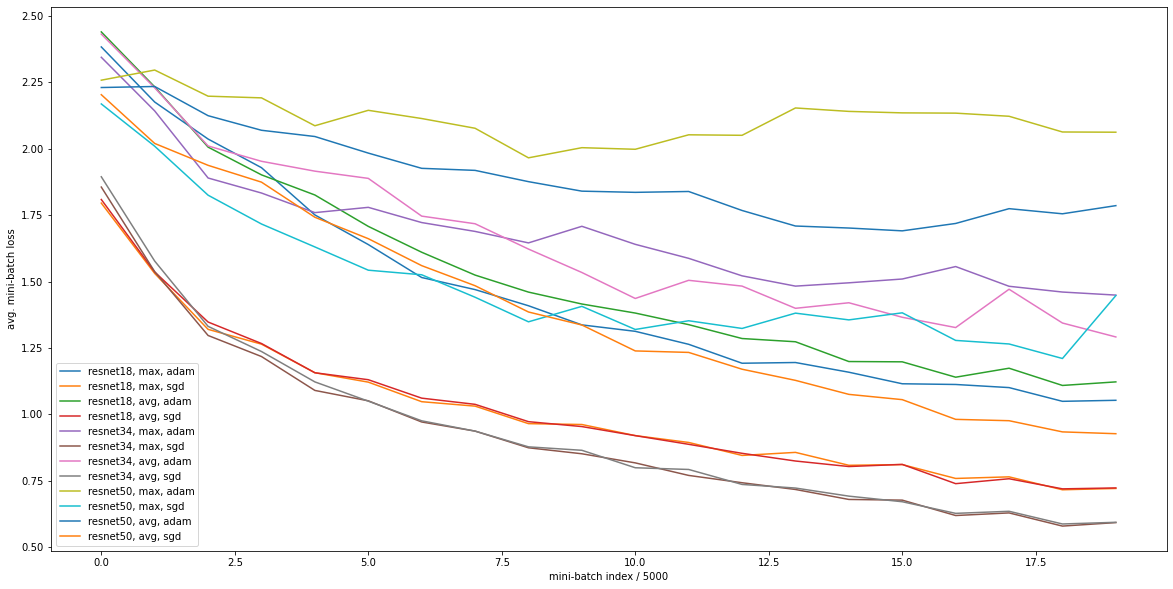

In [17]:
plt.figure(figsize=(20, 10))
for result in pkl:
    label = f"{result['version']}, {result['pooling_type']}, {result['optimizer']}"
    plt.plot(result['avg_loss'], label=label)

plt.xlabel('mini-batch index / 5000')
plt.ylabel('avg. mini-batch loss')
plt.legend()
plt.show()


Then, we plot the accuracies obtained by testing the trained models on our testing dataset.

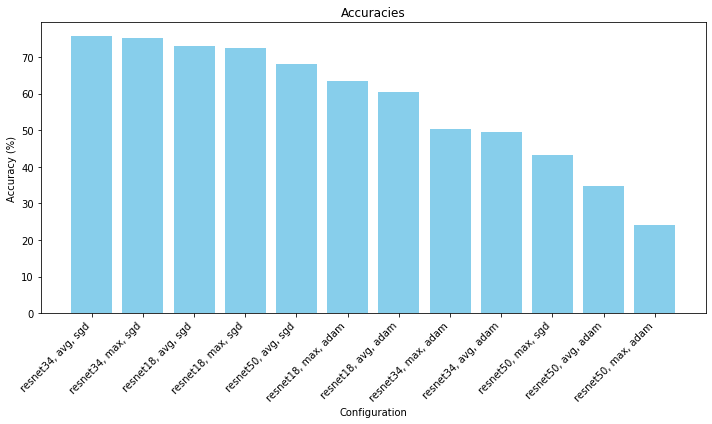

In [11]:
sorted_results = sorted(pkl, key=lambda x: x['accuracy'], reverse=True)
experiment_labels = [f"{r['version']}, {r['pooling_type']}, {r['optimizer']}" for r in sorted_results]
accuracies = [r['accuracy'] for r in sorted_results]
plt.figure(figsize=(10, 6))
plt.bar(experiment_labels, accuracies, color='skyblue')

plt.xlabel('Configuration')
plt.ylabel('Accuracy (%)')
plt.title('Accuracies')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Here, we can find an interesting trend. ResNet50 performs the worst of all models, and SGD optimizer yield overall better results than Adam optimizer. We found that the best performing configuration among the 12 is ResNet34 with average pooling and SGD optimizer.

We can test our models with image classfication task below.

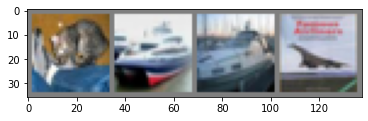

resnet34, avg, sgd
GroundTruth:    cat  ship  ship plane
Accuracy of plane : 84 %
Accuracy of   car : 82 %
Accuracy of  bird : 67 %
Accuracy of   cat : 58 %
Accuracy of  deer : 75 %
Accuracy of   dog : 65 %
Accuracy of  frog : 78 %
Accuracy of horse : 78 %
Accuracy of  ship : 80 %
Accuracy of truck : 84 %
Predicted:    cat  ship  deer plane


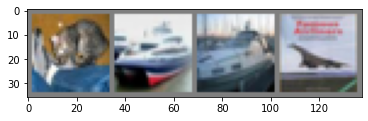

resnet34, max, sgd
GroundTruth:    cat  ship  ship plane
Accuracy of plane : 79 %
Accuracy of   car : 89 %
Accuracy of  bird : 71 %
Accuracy of   cat : 57 %
Accuracy of  deer : 77 %
Accuracy of   dog : 61 %
Accuracy of  frog : 77 %
Accuracy of horse : 78 %
Accuracy of  ship : 80 %
Accuracy of truck : 80 %
Predicted:    cat  ship   car plane


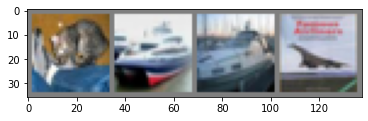

resnet18, avg, sgd
GroundTruth:    cat  ship  ship plane
Accuracy of plane : 82 %
Accuracy of   car : 86 %
Accuracy of  bird : 67 %
Accuracy of   cat : 52 %
Accuracy of  deer : 61 %
Accuracy of   dog : 61 %
Accuracy of  frog : 80 %
Accuracy of horse : 75 %
Accuracy of  ship : 80 %
Accuracy of truck : 81 %
Predicted:    dog   car   car plane


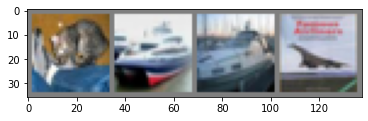

resnet18, max, sgd
GroundTruth:    cat  ship  ship plane
Accuracy of plane : 75 %
Accuracy of   car : 89 %
Accuracy of  bird : 60 %
Accuracy of   cat : 50 %
Accuracy of  deer : 73 %
Accuracy of   dog : 65 %
Accuracy of  frog : 74 %
Accuracy of horse : 76 %
Accuracy of  ship : 79 %
Accuracy of truck : 80 %
Predicted:    dog   car   car plane


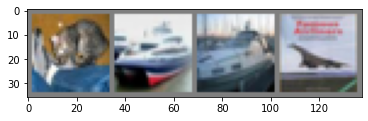

resnet50, avg, sgd
GroundTruth:    cat  ship  ship plane
Accuracy of plane : 70 %
Accuracy of   car : 81 %
Accuracy of  bird : 59 %
Accuracy of   cat : 51 %
Accuracy of  deer : 59 %
Accuracy of   dog : 57 %
Accuracy of  frog : 75 %
Accuracy of horse : 70 %
Accuracy of  ship : 76 %
Accuracy of truck : 77 %
Predicted:    cat   car truck plane


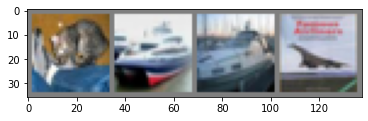

resnet18, max, adam
GroundTruth:    cat  ship  ship plane
Accuracy of plane : 67 %
Accuracy of   car : 76 %
Accuracy of  bird : 47 %
Accuracy of   cat : 28 %
Accuracy of  deer : 56 %
Accuracy of   dog : 62 %
Accuracy of  frog : 74 %
Accuracy of horse : 75 %
Accuracy of  ship : 76 %
Accuracy of truck : 71 %
Predicted:    dog   car plane  bird


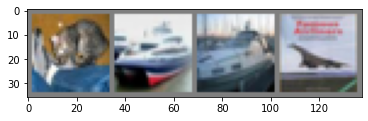

resnet18, avg, adam
GroundTruth:    cat  ship  ship plane
Accuracy of plane : 71 %
Accuracy of   car : 77 %
Accuracy of  bird : 33 %
Accuracy of   cat : 42 %
Accuracy of  deer : 51 %
Accuracy of   dog : 43 %
Accuracy of  frog : 67 %
Accuracy of horse : 68 %
Accuracy of  ship : 76 %
Accuracy of truck : 71 %
Predicted:    dog  ship truck plane


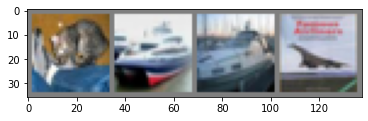

resnet34, max, adam
GroundTruth:    cat  ship  ship plane
Accuracy of plane : 61 %
Accuracy of   car : 65 %
Accuracy of  bird : 31 %
Accuracy of   cat : 34 %
Accuracy of  deer : 49 %
Accuracy of   dog : 30 %
Accuracy of  frog : 55 %
Accuracy of horse : 63 %
Accuracy of  ship : 61 %
Accuracy of truck : 49 %
Predicted:    cat   car   car plane


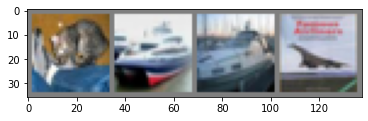

resnet34, avg, adam
GroundTruth:    cat  ship  ship plane
Accuracy of plane : 51 %
Accuracy of   car : 57 %
Accuracy of  bird : 36 %
Accuracy of   cat : 30 %
Accuracy of  deer : 38 %
Accuracy of   dog : 37 %
Accuracy of  frog : 59 %
Accuracy of horse : 56 %
Accuracy of  ship : 66 %
Accuracy of truck : 61 %
Predicted:    cat   car truck plane


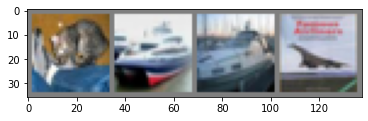

resnet50, max, sgd
GroundTruth:    cat  ship  ship plane
Accuracy of plane : 52 %
Accuracy of   car : 53 %
Accuracy of  bird : 31 %
Accuracy of   cat : 22 %
Accuracy of  deer : 37 %
Accuracy of   dog : 43 %
Accuracy of  frog : 49 %
Accuracy of horse : 39 %
Accuracy of  ship : 53 %
Accuracy of truck : 52 %
Predicted:    cat  ship plane plane


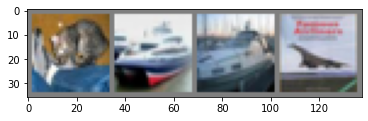

resnet50, avg, adam
GroundTruth:    cat  ship  ship plane
Accuracy of plane : 41 %
Accuracy of   car : 45 %
Accuracy of  bird : 13 %
Accuracy of   cat :  4 %
Accuracy of  deer : 32 %
Accuracy of   dog : 39 %
Accuracy of  frog : 38 %
Accuracy of horse : 46 %
Accuracy of  ship : 44 %
Accuracy of truck : 38 %
Predicted:    car   car truck plane


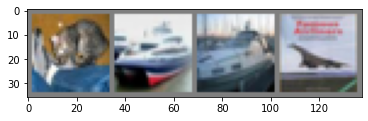

resnet50, max, adam
GroundTruth:    cat  ship  ship plane
Accuracy of plane : 42 %
Accuracy of   car : 37 %
Accuracy of  bird : 24 %
Accuracy of   cat :  5 %
Accuracy of  deer :  8 %
Accuracy of   dog : 14 %
Accuracy of  frog : 28 %
Accuracy of horse : 22 %
Accuracy of  ship : 29 %
Accuracy of truck : 28 %
Predicted:    dog truck plane plane


In [19]:
# Check several images.

for result in sorted_results:
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    print(f"{result['version']}, {result['pooling_type']}, {result['optimizer']}")
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    for c_ac in result['class_acc']:
        print(c_ac)
    outputs = result['model'](images.to(device))
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))